### X post generator

In [2]:
from langgraph.graph import StateGraph,START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import SystemMessage, HumanMessage
import operator

In [3]:

generator_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
evaluator_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')
optimizer_llm = ChatGoogleGenerativeAI(model='gemini-2.0-flash')

In [4]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs_improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [5]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [6]:
# state
class TweetState(TypedDict):

    topic: str
    tweet: str
    evaluation: Literal["approved", "needs_improvement"]
    feedback: str
    iteration: int
    max_iteration: int

    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [7]:
def generate_tweet(state: TweetState):

    # prompt
    messages = [
        SystemMessage(content="You are a funny and clever Twitter/X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    # send generator_llm
    response = generator_llm.invoke(messages).content

    # return response
    return {'tweet': response, 'tweet_history': [response]}

In [8]:
def evaluate_tweet(state: TweetState):

    # prompt
    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality – Is this fresh, or have you seen it a hundred times before?  
2. Humor – Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness – Is it short, sharp, and scroll-stopping?  
4. Virality Potential – Would people retweet or share it?  
5. Format – Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs_improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation':response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [9]:
def optimize_tweet(state: TweetState):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters.
""")
    ]

    response = optimizer_llm.invoke(messages).content
    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [10]:
def route_evaluation(state: TweetState):

    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs_improvement'

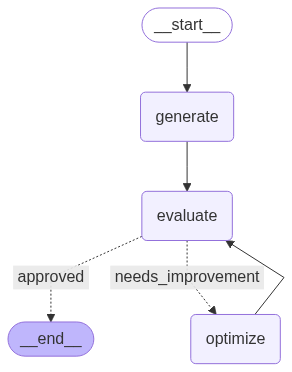

In [11]:
graph = StateGraph(TweetState)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs_improvement': 'optimize'})
graph.add_edge('optimize', 'evaluate')

workflow = graph.compile()

workflow

In [12]:
initial_state = {
    "topic": "srhberhb",
    "iteration": 1,
    "max_iteration": 5
}
result = workflow.invoke(initial_state)

In [13]:
result

{'topic': 'srhberhb',
 'tweet': '"srhberhb" is what my cat coughed up this morning. #IcelandVolcano #SorryNotSorry',
 'evaluation': 'needs_improvement',
 'feedback': "The tweet attempts humor by comparing a word to a cat's cough and referencing the Iceland volcano. However, the humor is weak, and the comparison isn't particularly funny or original. The hashtag #SorryNotSorry feels tacked on and doesn't add to the joke. The tweet also lacks punchiness; it's not particularly attention-grabbing. The virality potential is low because it's not relatable or humorous enough to encourage sharing.",
 'iteration': 5,
 'max_iteration': 5,
 'tweet_history': ['Me trying to pronounce the name of that Icelandic volcano again. #srhberhb #Iceland #GoodLuck',
  'Okay, here are a few options, playing with different angles of humor and virality potential, based on the "unpronounceable Icelandic volcano name" premise:\n\n**Option 1 (Playing on frustration/relatability):**\n\n> My therapist: "Just say what 

In [14]:
for tweet in result['tweet_history']:
    print(tweet)

Me trying to pronounce the name of that Icelandic volcano again. #srhberhb #Iceland #GoodLuck
Okay, here are a few options, playing with different angles of humor and virality potential, based on the "unpronounceable Icelandic volcano name" premise:

**Option 1 (Playing on frustration/relatability):**

> My therapist: "Just say what you're feeling."
> Me: *Tries to pronounce srhberhb*
> My therapist: "Okay, maybe not *everything*." #Iceland #Volcano #Anxiety

**Option 2 (Absurdist/Exaggerated):**

> srhberhb is Icelandic for "May cause spontaneous combustion of your tongue." #Iceland #Volcano #TIL

**Option 3 (Pop Culture Reference - if appropriate for your audience):**

> Voldemort: "I am Lord..."
> Me: *Whispers* srhberhb
> Voldemort: "Okay, you win. Take the Elder Wand." #Iceland #HarryPotter #Volcano

**Why these are better:**

*   **Stronger Humor:** They use either relatable situations (therapy, anxiety), absurdity (tongue combustion), or pop culture references to amplify the hum